# Counterfactual value estimation using outcome imputation

## Introduction
The goal in uplift modeling is usually to predict the best treatment condition for an individual. Most of the time, the best treatment condition is assumed to be the one that has the highest probability of some "conversion event" such as the individual's purchasing a product. This is the traditional approach in which the goal is to maximize conversion.

However, if the goal of uplift modeling is to maximize value, then it is not safe to assume that the best treatment group is the one with the highest expected conversion. For example, it might be that the payoff from conversion is not sufficient to offset the cost of the treatment, or it might be that the treatment targets individuals who would convert anyway [(Li and Pearl 2019)](https://ftp.cs.ucla.edu/pub/stat_ser/r488.pdf). Therefore, it is often important to conduct some kind of value optimization together with uplift modeling, in order to determine the treatment group with the best value, not just the best lift.

The Causal ML package includes the CounterfactualValueEstimator class to conduct simple imputation-based value optimization. This notebook demonstrates the use of CounterfactualValueEstimator to determine the best treatment group when the costs of treatments are taken into account. We consider two kinds of costs:

* **Conversion costs** are those that we must endure if an individual who is in the treatment group converts. A typical example would be the cost of a promotional voucher.
* **Impression costs** are those that we need to pay for each individual in the treatment group irrespective of whether they convert. A typical example would be the cost associated with sending an SMS or email.

The proposed method takes two inputs: the CATE estimate $\hat{\tau}$ learned by any suitable method, and the predicted outcome for an individual learned by what we call the conversion probability model that estimates the conditional probability of conversion $P(Y=1 \mid X=x, W=x)$ where $W$ is the treatment group indicator. That is, the model estimates the probability of conversion for each individual using their observed pre-treatment features $X$. The output of this model is then combined with the predicted CATE in order to impute the expected conversion probability for each individual under \textit{each treatment condition} as follows:

\begin{equation}
\hat{Y}_i^0 = 
    \begin{cases}
    \hat{m}(X_i, W_i) & \text{for } W_i = 0 \\
    \hat{m}(X_i, W_i) - \hat{\tau}_t(X_i) & \text{for } W_i = t \\
    \end{cases}
\end{equation}

\begin{equation}
\hat{Y}_i^t = 
    \begin{cases}
    \hat{m}(X_i, W_i) + \hat{\tau}_t(X_i) & \text{for } W_i = 0 \\
    \hat{m}(X_i, W_i) & \text{for } W_i = t \\
    \end{cases}
\end{equation}

The fact that we impute the conversion probability under each experimental condition--the actual as well as the counterfactual--gives our method its name. Using the estimated conversion probabilities, we then compute the expected payoff under each treatment condition while taking into account the value of conversion and the conversion and impression costs associated with each treatment, as follows (see [Zhao and Harinen (2019)](https://arxiv.org/abs/1908.05372) for more details):

\begin{equation}
    \mathbb{E}[(v - cc_t)Y_t - ic_t]
\end{equation}

where $cc_t$ and $ic_t$ are the conversion costs and impression costs, respectively.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import xgboost as xgb

from causalml.dataset import make_uplift_classification
from causalml.inference.meta import BaseTClassifier
from causalml.optimize import CounterfactualValueEstimator
from causalml.optimize import get_treatment_costs
from causalml.optimize import get_actual_value

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


## Data generation

First, we simulate some heterogeneous treatment data using the built-in function.

In [2]:
df, X_names = make_uplift_classification(
    n_samples=5000, treatment_name=['control', 'treatment1', 'treatment2'])

In this example, we assume there are no costs associated with assigning units into the control group, and that for the two treatment groups the conversion cost are \\$2.5 and \\$5, respectively. We assume the impression costs to be zero for one of the treatments and \\$0.02 for the other. We also specify the payoff, which we here assume to be the same for everyone, \\$20. However, these values could vary from individual to individual.

In [3]:
# Put costs into dicts
conversion_cost_dict = {'control': 0, 'treatment1': 2.5, 'treatment2': 5}
impression_cost_dict = {'control': 0, 'treatment1': 0, 'treatment2': 0.02}

# Use a helper function to put treatment costs to array
cc_array, ic_array, conditions = get_treatment_costs(treatment=df['treatment_group_key'],
                                                     control_name='control',
                                                     cc_dict=conversion_cost_dict,
                                                     ic_dict=impression_cost_dict)

# Put the conversion value into an array
conversion_value_array = np.full(df.shape[0], 20)

Next we calculate the value of actually having an individual in their actual treatment group using the equation for expected value under a treatment, ie:

\begin{equation}
    \mathbb{E}[(v - cc_t)Y_t - ic_t]
\end{equation}

In [4]:
# Use a helper function to obtain the value of actual treatment
actual_value = get_actual_value(treatment=df['treatment_group_key'],
                                observed_outcome=df['conversion'],
                                conversion_value=conversion_value_array,
                                conditions=conditions,
                                conversion_cost=cc_array,
                                impression_cost=ic_array)

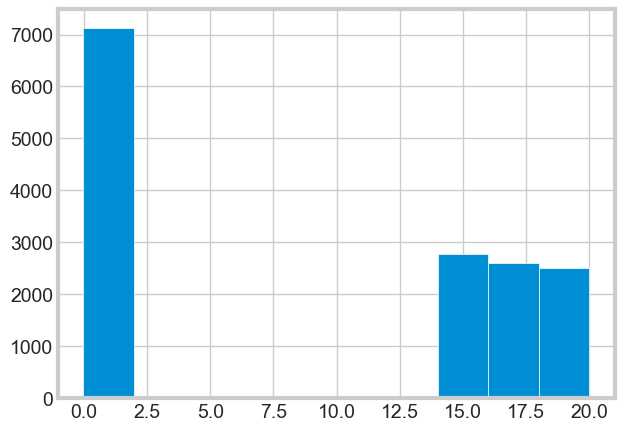

In [5]:
plt.hist(actual_value)
plt.show()

## Model evaluation

A common problem in the uplift modeling literature is that of evaluating the quality of the treatment recommendations produced by a model. The evaluation of uplift models is tricky because we do not observe treatment effects at an individual level directly in non-simulated data, so it is not possible to use standard model evaluation metrics such as mean squared error. Consequently, various authors have proposed various ways to work around this issue. For example, [Schuler et al (2018)](https://arxiv.org/abs/1804.05146) identify seven different evaluation strategies used in the literature. 

Below, we use the approach of model evaluation put forward by [Kaepelner et al (2014)](https://arxiv.org/abs/1404.7844). The idea in this method is to evaluate the improvement we would gain if we targeted some as-yet untreated future population by using the recommendations produced by a particular model. To do so, we split the data into disjoint training and testing sets, and train our model on the training data. We then use the model to predict the best treatment group for units in the testing data, which in a simple two-arm trial is either treatment or control. In order to estimate the outcome for the future population if the model were to be used, we then select a subset of the testing data based on whether their observed treatment allocation happens to be the same as the one recommended by the model. This population is called "lucky".

| Predicted best treatment | Actual treatment | Lucky |
|--------------------------|------------------|-------|
| Control | Control | Yes |
| Control | Treatment | No |
| Treatment | Treatment | Yes |
| Treatment | Control | No |

The average outcome for the "lucky" population can be taken to represent what the outcome would be for a future untreated population if we were to use the uplift model in question to allocate treatments. Recall that in all of the experiments the treatments are assumed to have been allocated randomly across the total population, so there should be no selection bias. The average outcome under a given model can then be compared with alternative treatment allocation strategies. As [Kaepelner et al (2014)](https://arxiv.org/abs/1404.7844) point out, two common strategies are random allocation and "best treatment" allocation. To estimate what the outcome for a future population would be under random allocation, we can simply look at the sample mean across the total test population. To estimate the same for the "best treatment" assignment, we can look at those units in the test set whose observed treatment assignment corresponds to the treatment group with the best average treatment effect. These alternative targeting strategies are interesting because they are a common practice in industry applications and elsewhere.

### Performance against benchmarks

In this section, we compare four different targeting strategies:

* Random treatment allocation under which all units in the testing set are randomly assigned to treatments
* The "best treatment" allocation under which all units in the testing set are assigned to the treatment with the best conversion in the training set
* Allocation under an uplift model in which all units in the testing set are assigned to the treatment which is predicted to have the highest conversion rate according to an uplift model trained on the training set
* Allocation under the counterfactual value estimator model in which all units are assigned to the treatment group with the best predicted payoff

In [6]:
df_train, df_test = train_test_split(df)
train_idx = df_train.index
test_idx = df_test.index

In [7]:
# Calculate the benchmark value according to the random allocation
# and best treatment schemes
random_allocation_value = actual_value.loc[test_idx].mean()

best_ate = df_train.groupby(
    'treatment_group_key')['conversion'].mean().idxmax()

actual_is_best_ate = df_test['treatment_group_key'] == best_ate

best_ate_value = actual_value.loc[test_idx][actual_is_best_ate].mean()

In [8]:
# Calculate the value under an uplift model 
tm = BaseTClassifier(control_learner=xgb.XGBClassifier(),
                     treatment_learner=xgb.XGBClassifier(),
                     control_name='control')

tm.fit(df_train[X_names].values,
       df_train['treatment_group_key'],
       df_train['conversion'])

tm_pred = tm.predict(df_test[X_names].values)

pred_df = pd.DataFrame(tm_pred, columns=tm._classes)
tm_best = pred_df.idxmax(axis=1)
actual_is_tm_best = df_test['treatment_group_key'] == tm_best.ravel()
tm_value = actual_value.loc[test_idx][actual_is_tm_best].mean()

In [9]:
# Estimate the conditional mean model; this is a pure curve
# fitting exercise
proba_model = xgb.XGBClassifier()

W_dummies = pd.get_dummies(df['treatment_group_key'])
XW = np.c_[df[X_names], W_dummies]

proba_model.fit(XW[train_idx], df_train['conversion'])
y_proba = proba_model.predict_proba(XW[test_idx])[:, 1]

In [10]:
# Run the counterfactual calculation with TwoModel prediction
cve = CounterfactualValueEstimator(treatment=df_test['treatment_group_key'],
                                   control_name='control',
                                   treatment_names=conditions[1:],
                                   y_proba=y_proba,
                                   cate=tm_pred,
                                   value=conversion_value_array[test_idx],
                                   conversion_cost=cc_array[test_idx],
                                   impression_cost=ic_array[test_idx])

cve_best_idx = cve.predict_best()
cve_best = [conditions[idx] for idx in cve_best_idx]
actual_is_cve_best = df.loc[test_idx, 'treatment_group_key'] == cve_best
cve_value = actual_value.loc[test_idx][actual_is_cve_best].mean()

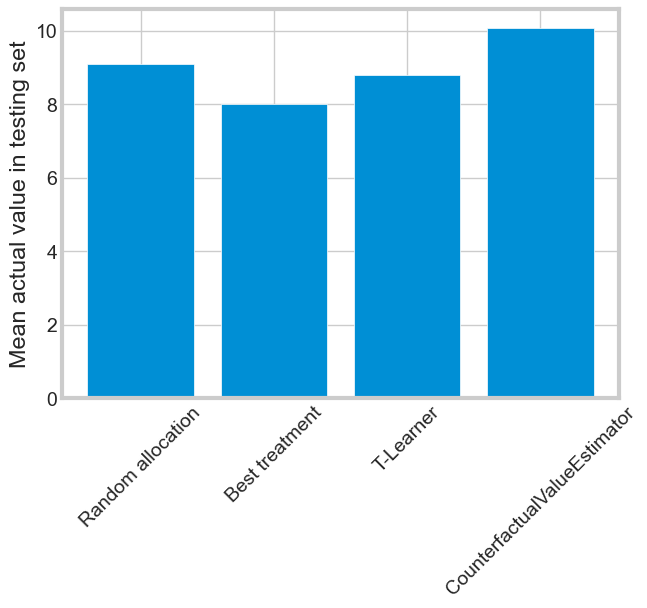

In [11]:
labels = [
    'Random allocation',
    'Best treatment',
    'T-Learner',
    'CounterfactualValueEstimator'
]

values = [
    random_allocation_value,
    best_ate_value,
    tm_value,
    cve_value
]

plt.bar(labels, values)
plt.ylabel('Mean actual value in testing set')
plt.xticks(rotation=45)
plt.show()

Here, only CounterfactualValueEstimator improves upon random targeting. The "best treatment" and T-Learner approaches likely perform worse because they recommend costly treatments to individuals who would convert anyway.